In [1]:
import numpy as np
import pandas as pd
import re 
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
# Lmao kolaveridi is this guys git 
airline_tweets = pd.read_csv(data_url)

In [5]:
airline_tweets.head()
# pandas dataframe head gives a glipse of the strucutre of data


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
plot_size = plt.rcParams["figure.figsize"]
print(plot_size)

[6.0, 4.0]


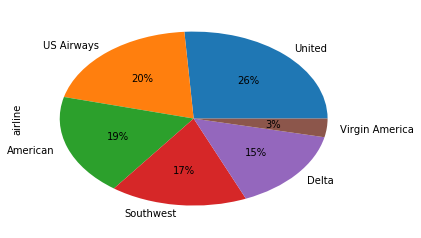

In [7]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')


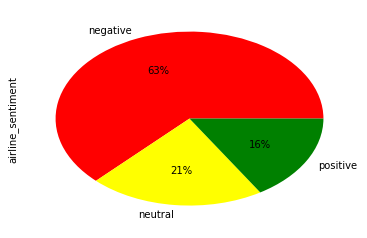

In [8]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

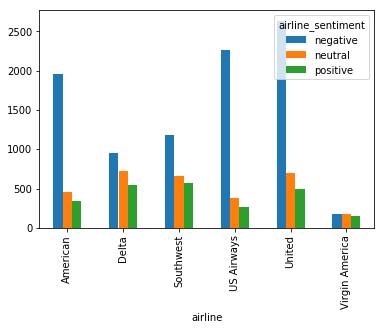

In [9]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [10]:
# Data pipeline starts here
# iloc is like index but pandas dataframe stores everything in rows
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [12]:
# String parsing and cleaning using regex
processed_features = []
for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    processed_features.append(processed_feature)

In [14]:
# Vectorization of text to input into machine learning
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [16]:
# Classic line for test and training dataset division
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [17]:
# Random forest is esentially a thiccc decision tree
# This step takes time ~3 mins
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
predictions = text_classifier.predict(X_test)

In [20]:
# How good are your predictions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995
